# Линейная регрессия
__Суммарное количество баллов: 10__


In [1]:
from sklearn.datasets import make_blobs, make_moons
from sklearn.model_selection import train_test_split
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib
import copy
import jax
import jax.numpy as jnp
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler

SEED = 19

In [2]:
def read_data(path="./hw8_data/boston.csv"):
    dataframe = np.genfromtxt(path, delimiter=",", skip_header=15)
    X = dataframe[:, :-1]
    y = dataframe[:, -1]
    return X, y

In [3]:
def generate_synthetic(size, dim=6, noise=0.1):
    X = np.random.randn(size, dim)
    w = np.random.randn(dim + 1)
    noise = noise * np.random.randn(size)
    y = X.dot(w[1:]) + w[0] + noise
    return X, y

### Задание 1 (1 балл)
Для начала нужно понять, какую метрику для ошибки будем использовать. В нашем случае нам подойдет стандартная метрика MSE. Ее и нужно реализовать.

In [4]:
def mse(y_true, y_predicted):
    return np.mean((y_true - y_predicted)**2)

### Задание 2 (3 балла)
Теперь реализуем линейную регрессию при помощи явного решения задачи минимизации. 

#### Методы
`fit(X, y)` - решает задачу минимизации $\arg\min_{w, b}\sum ((w\cdot x + b) - y)^2$. 

`predict(X)` - строит предсказание `y` для объектов из `X`.

In [5]:
class NormalLR:
    def __init__(self):
        self.weights = None
    
    def fit(self, X, y):
        n_objects = X.shape[0]
        X = np.concatenate((np.ones(n_objects).reshape(-1, 1), X), axis=1)
        self.weights = np.linalg.inv(X.T@X)@X.T@y
    
    def predict(self, X):
        n_objects = X.shape[0]
        X = np.concatenate((np.ones(n_objects).reshape(-1, 1), X), axis=1)
        return X@self.weights

In [6]:
np.random.seed(SEED)
X, y = generate_synthetic(1024)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

In [7]:
regr = NormalLR()
regr.fit(X_train, y_train)
print(mse(y_test, regr.predict(X_test)))

0.010008031536213277


### Задание 3 (2 балла)
Теперь реализуем линейную регрессию с использованием градиентного спуска с larning rate `alpha` в течении `iterations` итераций.

#### Методы
`fit(X, y)` - приближает решение задачи минимизации $\arg\min_{w, b}\sum ((w\cdot x + b) - y)^2$ при помощи градиентного спуска. 


`predict(X)` - строит предсказание `y` для объектов из `X`.

In [8]:
class GradientLR:
    def __init__(self, alpha, iterations=10000, verbose=True, random_seed=SEED):
        self.alpha = alpha
        self.iterations = iterations
        self.verbose = verbose
        self.random_seed = random_seed
        self.weights = None
    
    def fit(self, X, y):
        key = jax.random.PRNGKey(self.random_seed)
        n_objects, n_features = X.shape
        # добавляем фиктивную размерность для отступа
        X_jnp = jnp.concatenate((jnp.ones(n_objects).reshape(-1, 1), jnp.array(X)), axis=1)
        y_jnp = jnp.array(y)
        # инициализируем веса
        weights = jnp.zeros(n_features + 1)
        # функция потерь
        @jax.jit
        def loss(X, y, weights):
            return jnp.mean((y - X@weights)**2)
        # запускаем градиентный спуск
        for _ in tqdm(range(self.iterations)) if self.verbose else range(self.iterations):
            weights -= self.alpha * jax.grad(loss, argnums=2)(X_jnp, y_jnp, weights)
        self.weights = np.array(weights)

    def predict(self, X):
        n_objects = X.shape[0]
        X_mod = np.concatenate((np.ones(n_objects).reshape(-1, 1), X), axis=1)
        return X_mod@self.weights

In [9]:
np.random.seed(SEED)
X, y = generate_synthetic(1024)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

In [10]:
regr = GradientLR(alpha=0.001, iterations=5000)
regr.fit(X_train, y_train)
print(mse(y_test, regr.predict(X_test)))

100%|██████████| 5000/5000 [00:08<00:00, 612.55it/s]

0.010005076594071162


### Задание 4 (2 балла)
Добавьте в метод `fit` регуляризацию Лассо с коэффициентом `l`. Постройте график зависимости ошибки предсказания данных из синтетического набора данных от коэффициента регуляризации.

In [11]:
class GradientLR:
    def __init__(self, alpha, iterations=10000, l=0, verbose=True, random_seed=SEED):
        self.alpha = alpha
        self.iterations = iterations
        self.l = l
        self.verbose = verbose
        self.random_seed = random_seed
        self.weights = None
    
    def fit(self, X, y):
        key = jax.random.PRNGKey(self.random_seed)
        n_objects, n_features = X.shape
        # добавляем фиктивную размерность для отступа
        X_jnp = jnp.concatenate((jnp.ones(n_objects).reshape(-1, 1), jnp.array(X)), axis=1)
        y_jnp = jnp.array(y)
        # инициализируем веса
        weights = jnp.zeros(n_features + 1)
        # функция потерь
        @jax.jit
        def loss(X, y, weights):
            return jnp.mean((y - X@weights)**2) + self.l*jnp.sum(jnp.abs(weights))
        # запускаем градиентный спуск
        for _ in tqdm(range(self.iterations)) if self.verbose else range(self.iterations):
            weights -= self.alpha * jax.grad(loss, argnums=2)(X_jnp, y_jnp, weights)
        self.weights = np.array(weights)

    def predict(self, X):
        n_objects = X.shape[0]
        X_mod = np.concatenate((np.ones(n_objects).reshape(-1, 1), X), axis=1)
        return X_mod@self.weights

In [12]:
def build_plot(X_train, y_train, X_test, y_test, l_list):
    loss_list = []
    for l in tqdm(l_list):
        regr = GradientLR(0.01, iterations=1000, l=l, verbose=False)
        regr.fit(X_train, y_train)
        loss_list.append(mse(y_test, regr.predict(X_test)))
    plt.figure(figsize=(8, 6))
    plt.title("MSE for different L1-reg. coeficients", fontsize=20)
    plt.ylabel("Loss", fontsize=15)
    plt.xlabel("L1-reg. weight", fontsize=15)
    plt.grid()
    plt.xscale("log")
    plt.plot(l_list, loss_list);
    return l_list, loss_list

In [13]:
X, y = generate_synthetic(1024)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

In [14]:
regr = GradientLR(0.1, iterations=1000, l=0.01)
regr.fit(X_train, y_train)
print(mse(y_test, regr.predict(X_test)))

100%|██████████| 1000/1000 [00:02<00:00, 455.43it/s]

0.010006648061213328


100%|██████████| 5/5 [00:08<00:00,  1.77s/it]


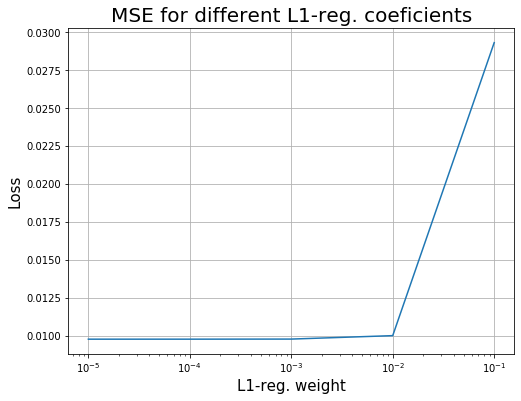

In [15]:
l1_coefs, losses = build_plot(X_train, y_train, X_test, y_test, l_list=np.logspace(-5, -1, 5))

### Задание 5 (2 балла)
Протесируйте оба метода на данных cancer и spam, для градиентного спуска постройте график зависимости ошибки от коэффициента регуляризации. 

### Spam

In [16]:
X, y = read_data("./hw8_data/spam.csv")
scaler = StandardScaler()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=False)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [17]:
regr = GradientLR(0.01, iterations=1000)
regr.fit(X_train, y_train)
print(mse(y_test, regr.predict(X_test)))

100%|██████████| 1000/1000 [00:02<00:00, 483.44it/s]

0.18890220064757662


100%|██████████| 5/5 [00:10<00:00,  2.04s/it]


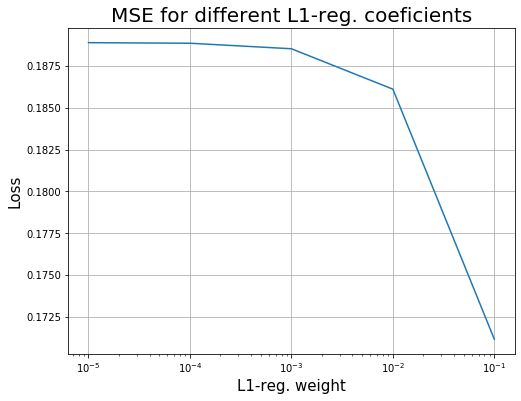

In [18]:
l1, losses = build_plot(X_train, y_train, X_test, y_test, l_list=np.logspace(-5, -1, 5))

### Cancer

In [19]:
import pandas as pd
data = pd.read_csv("./hw8_data/cancer.csv")
X, y = data.drop(columns=["label"]).values, data.label.map({"M": 0, "B": 1}).values
scaler = StandardScaler()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=False)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [20]:
regr = GradientLR(0.01, iterations=1000)
regr.fit(X_train, y_train)
print(mse(y_test, regr.predict(X_test)))

100%|██████████| 1000/1000 [00:02<00:00, 493.07it/s]

0.06380053977880928


100%|██████████| 6/6 [00:10<00:00,  1.78s/it]


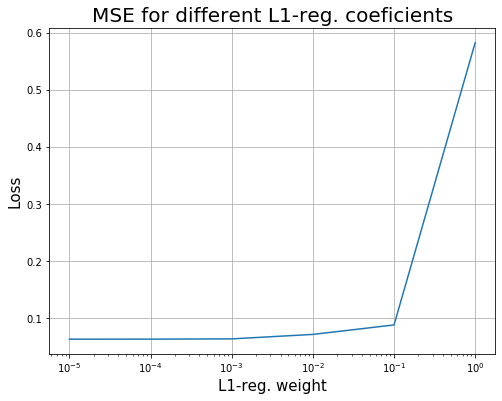

In [21]:
l1, losses = build_plot(X_train, y_train, X_test, y_test, l_list=np.logspace(-5, 0, 6))